## Capstone Project 1: Modelling Cycle Hire Network
### Part 2: Data Storytelling

<b>In this section of the project, we will use visualization tools such as [`bokeh`](https://docs.bokeh.org/en/latest/docs/reference.html) to look at relationships between data. Ideally, we want to see linear realtionships between the number of rides/duration of rides and the features we have selected such as type of day, weather and hour of day.

In [33]:
import numpy as np
import pandas as pd
from scipy import stats

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, save
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from matplotlib import pyplot as plt
output_notebook()

Loading BokehJS ...

<b>We will first look at the relationship between number of hires per hour and weather data such as temperature, wind speed and type of weather. Before we get to plotting, we will first define a plotting function, `linear_reg_gridplot()` that will plot the scatter plot and histogram of any two varaiables. This function will also use [`np.polyfit()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) to fit the data using linear regression and display the mean-squared error(MSE) of the fit on the plot. 

In [2]:
#download cleaned cycle hire data
cycle_df = pd.read_csv('data/cycle_df_weather.csv', parse_dates=[0, 1, 3])

In [45]:
def r_squared(SSres, y):
    
    SStot = np.sum(np.square(y - np.mean(y)))
    return round(1 - SSres/SStot, 2)

def linear_reg_gridplot(x, y, title, xlabel, ylabel, normalize_values=True):
    """plots scatter, regression line and histograms of 2 variables"""
       
    #normalize x, y  
    if normalize_values == True:
        y = (y - np.mean(y))/np.std(y)
        x = (x - np.mean(x))/np.std(x)
    
    # compute the linear regression line for dataset
    fit = np.polyfit(x, y, 1, full=True)
    x_reg = [min(x), max(x)]
    y_reg = [fit[0][0]*i + fit[0][1] for i in x_reg]
    
    # plot scatter plot and fitted line 
    p = figure(toolbar_location='above', plot_width=600, plot_height=400, title=title)
    p.scatter(x, y, size=3, color="#3A5785", alpha=0.6)
    p.line(x_reg, y_reg, color='red', line_width=3, legend='R-squared: ' + str(r_squared(fit[1][0], y)))
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel

    # plot horizontal histogram - distribution of x values
    hhist, hedges = np.histogram(x, bins=20)
    hzeros = np.zeros(len(hedges)-1)
    ph = figure(toolbar_location=None, plot_width=p.plot_width, plot_height=150, x_range=p.x_range,
            y_range=(0, max(hhist)*1.1), min_border=10, min_border_left=50, y_axis_location="left")
    ph.quad(bottom=0, left=hedges[:-1], right=hedges[1:], top=hhist, color='white', line_color="#3A5785")

    # plot vertical histogram - distribution of y values
    vhist, vedges = np.histogram(y, bins=20)
    vzeros = np.zeros(len(vedges)-1)
    pv = figure(toolbar_location=None, plot_width=200, plot_height=p.plot_height, x_range=(0, max(vhist)*1.1),
            y_range=p.y_range, min_border=10, x_axis_location="above", y_axis_location="right")
    pv.xaxis.major_label_orientation = -np.pi/2
    pv.quad(left=0, bottom=vedges[:-1], top=vedges[1:], right=vhist, color="white", line_color="#3A5785")


    layout = gridplot([[ph, None], [p, pv]], merge_tools=False)
    return(layout)

In [5]:
hourly_hire_group = cycle_df.groupby(['Date', 'hour'])

<b>See plots below showing relationship between weather data and hourly ride count. We can see that the hourly hire rate is positively correlated with temperature and good weather conditions. However, there is not enough evidence to show correlation between wind speed and ride count.

In [46]:
# plot relationship between hourly cycle hire count and average temperature
plot = linear_reg_gridplot(hourly_hire_group.mean()['Temperature'], hourly_hire_group.count()['Duration(mins)'],  
                   'Hourly Hire Rate vs Temperature', 'Avg Temperature(Normalized)', 'Bikes Hired per Hour(Normalized)')
show(plot)
output_file("images/temp_relationship.html")
save(plot)

'C:\\Users\\kc\\github\\SpringboardProjects\\Capstone Project\\images\\temp_relationship.html'

In [47]:
# plot relationship between hourly cycle hire count and average wind speed
plot = linear_reg_gridplot(hourly_hire_group.mean()['Wind Speed'], hourly_hire_group.count()['Duration(mins)'],  
                   'Hourly Hire Rate vs Wind Speed', 'Avg Wind Spd(Normalized)', 'Bikes Hired per Hour(Normalized)')
show(plot)
output_file("images/wind_relationship.html")
save(plot)

'C:\\Users\\kc\\github\\SpringboardProjects\\Capstone Project\\images\\wind_relationship.html'

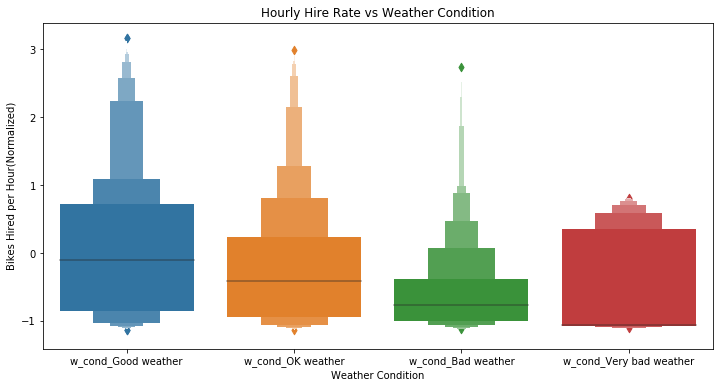

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# set up dataframe with just 2 columns: weather type and hourly ride rate - easier to plot
weather_cond = hourly_hire_group.mean()[['w_cond_Bad weather', 'w_cond_Good weather', 'w_cond_OK weather', 'w_cond_Very bad weather']].idxmax(axis=1)
hourly_count = hourly_hire_group.count()['Duration(mins)']
hourly_count_norm = (hourly_count - np.mean(hourly_count))/np.std(hourly_count)
df = pd.concat([weather_cond, hourly_count_norm], axis=1).rename(columns={0: 'weather'})

plt.figure(figsize=(12,6))
plt.title('Hourly Hire Rate vs Weather Condition')
sns_plot = sns.boxenplot(x="weather", y="Duration(mins)", data=df)
plt.xlabel('Weather Condition')
plt.ylabel('Bikes Hired per Hour(Normalized)')
plt.show()
sns_plot.figure.savefig("images/wcond_relationship.png")

<b>We can now look at how the type of day affects the number of rides and duration of rides. Here, we use an interactive legend for the type of day and look at the data by hour. We can see that number of bikes hired is greater on a weekday with peak hiring times around morning and evening peak hours. As for the average duration, the peaks are around late night or early morning when alternative transport modes are limited. 

In [39]:
def plot_scatter_by_day(data, ylabel, title):

    source1 = ColumnDataSource(data[data.day_code == 'W'])
    source2 = ColumnDataSource(data[data.day_code == 'WD'])
    source3 = ColumnDataSource(data[data.day_code == 'PH'])

    p = figure(x_range=data.hour.unique(), plot_width=800, plot_height=400, title=title)
    p.circle(x='hour', y='Duration(mins)', source=source1, alpha=0.6, legend='Weekday')
    p.square(x='hour', y='Duration(mins)', source=source2, alpha=0.6, legend='Weekend', color='red')
    p.triangle(x='hour', y='Duration(mins)', source=source3, alpha=0.6, legend='Public Holiday', color='green')

    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    p.xaxis.axis_label = 'Hour of Day'
    p.yaxis.axis_label = ylabel

    return(p)

In [48]:
day_group = cycle_df.groupby(['Date', 'hour', 'day_code'])
data = day_group.count()['Duration(mins)'].reset_index()
data.hour = data.hour.astype(str)
duration = data['Duration(mins)']
data['Duration(mins)'] = (duration -np.mean(duration))/len(duration)

plot = plot_scatter_by_day(data, 'Bikes Hired per Hour(Normalized)', 'Hourly Hire Rate vs Hour of Day')
show(plot)
output_file("images/hour_relationship.html")
save(plot)

'C:\\Users\\kc\\github\\SpringboardProjects\\Capstone Project\\images\\hour_relationship.html'

In [49]:
data_time_avg = day_group.mean()['Duration(mins)'].reset_index()
data_time_avg.hour = data_time_avg.hour.astype(str)

plot = plot_scatter_by_day(data_time_avg, 'Avg Duration for Hourly Bike Usage(mins)', 'Avg Duration vs Hour of Day')
show(plot)
output_file("images/hour_dur_relationship.html")
save(plot)

'C:\\Users\\kc\\github\\SpringboardProjects\\Capstone Project\\images\\hour_dur_relationship.html'

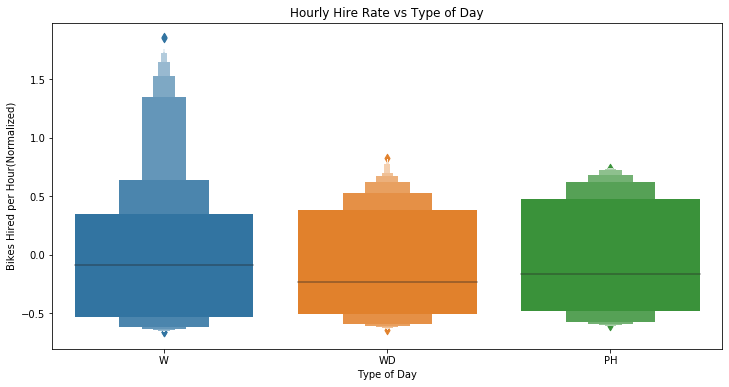

In [20]:
plt.figure(figsize=(12,6))
plt.title('Hourly Hire Rate vs Type of Day')
sns_plot = sns.boxenplot(x="day_code", y="Duration(mins)", data=data)
plt.xlabel('Type of Day')
plt.ylabel('Bikes Hired per Hour(Normalized)')
plt.show()
sns_plot.figure.savefig("images/day_type_relationship.png")

<b>In the previous plots, we suspect that the average duration and the number of rides might be inversely proportional. Below, we try to visualise the relationship between the 2 variables. We can see that the higher hourly bike hire rates are concentrated towards lower average durations. 

In [42]:
plot = linear_reg_gridplot(hourly_hire_group.mean()['Duration(mins)'], hourly_hire_group.count()['Duration(mins)'],  
                   'Hourly Hire Rate vs Avg Duration', 'Avg Duration(Normalized)', 'Bikes Hired per Hour(Normalized)')
show(plot)
output_file("images/count_dur_relationship.html")
save(plot)

'C:\\Users\\kc\\github\\SpringboardProjects\\Capstone Project\\images\\count_dur_relationship.html'